In [4]:
import sqlite3
import pandas as pd
from ggplot import *
from datetime import date, datetime, timedelta
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import statsmodels.api as sm

In [5]:
conn = sqlite3.connect('pv_production_CA.db')
cur = conn.cursor()

In [6]:
cur.execute("SELECT name FROM sqlite_master WHERE type='table';")
print(cur.fetchall())

[(u'la_gen',), (u'redd_gen',), (u'fres_gen',)]


In [7]:
la_gen = pd.read_sql_query("SELECT * from la_gen", conn)

In [8]:
redd_gen = pd.read_sql_query("SELECT * from redd_gen", conn)

In [9]:
fres_gen = pd.read_sql_query("SELECT * from fres_gen", conn)

In [10]:
conn.close()

In [11]:
### concatenate dataframes vertically

In [12]:
# First, create a new column in each table with the city name

In [13]:
la_gen['city'] =  'los_angeles'
redd_gen['city'] = 'redding'
fres_gen['city'] = 'fresno'

In [14]:
frames = [la_gen, redd_gen, fres_gen]
gen_data = pd.concat(frames)

In [15]:
del(la_gen)
del(redd_gen)
del(fres_gen)

In [16]:
## Sort and convert variables to the correct formats

In [17]:
gen_data.head()

,index,date_time,generation,hour,city
0,0,2017-01-01 00:00:00,0.0,00,los_angeles
1,1,2017-01-01 01:00:00,0.0,01,los_angeles
2,2,2017-01-01 02:00:00,0.0,02,los_angeles
3,3,2017-01-01 03:00:00,0.0,03,los_angeles
4,4,2017-01-01 04:00:00,0.0,04,los_angeles


In [18]:
# Second thing first: converting variables
gen_data['date_time'].dtype

dtype('O')

In [19]:
gen_data['date_time'] = pd.to_datetime(gen_data['date_time'], format = '%Y-%m-%d %H:%M:%S')

In [20]:
gen_data['generation'] = gen_data['generation'].astype('float')

In [21]:
### To test simulations, extract a sample month

In [22]:
gen_june = gen_data[(gen_data['date_time'] >= datetime.strptime('2017-06-01 00:00:00','%Y-%m-%d %H:%M:%S')) & (gen_data['date_time'] <= datetime.strptime('2017-06-30 00:00:00','%Y-%m-%d %H:%M:%S'))]

In [23]:
### For simulations, link load to generic weather variable (e.g. temperature) as counterfactual
### For treatment, link load to weather variable as well as a given generator

In [24]:
## Load simulation: use a "base" load profile

In [25]:
### Randomly create variation in each hours' load by creating a vector of random numbers mean = 0 for each hour
mu, sigma = 0, 1 # mean and standard deviation
wiggle = np.random.normal(mu, sigma, 24*30)

In [26]:
## Create load curve for base load profile
load_lst = []
load_lst = [10,10,9,8,10,14,17,18,20,21,25,28,31,32,37,38,42,43,44,46,40,35,30,20]

In [27]:
load_base =  {'hour': [x for x in range(24)],
                'base': load_lst}

load_base = pd.DataFrame(load_base)

In [28]:
load_base.tail()

,base,hour
19,46,19
20,40,20
21,35,21
22,30,22
23,20,23


In [29]:
## Creates hourly loads for each hour of the month, adjusted by a random variable mean=0 and sd=1,
## then multiplied by .1 times base load. This means, for example, that an event that is 1 sd is 10%
## above the base load for that hour. 
load_month = [((wiggle[(0+i2) + (23*i1)]*(.1*j)) + j) for i1,i in enumerate(range(30)) for i2,j in enumerate(load_base.base)]

In [30]:
## Convert load_month to a dataframe
load_act = {'load_hr': load_month}
load_act = pd.DataFrame(load_act)

In [31]:
## Create two lists with days and hours
hours = [j for i in range(30) for j in range(24)]
day = []
for i in range(30):
    for j in range(24):
        day.append(i+1)

In [32]:
load_act['day'] = day

In [33]:
load_act['hour'] = hours

In [34]:
## Create index
ind = []
for i in range(720):
    ind.append(i)

In [35]:
load_act['index'] = ind

In [36]:
### simulate solar output

In [37]:
## Pull June generation from the three cities
jun_gen_data = gen_data[(gen_data['date_time'] >= datetime.strptime('06/01/2017 00','%m/%d/%Y %H')) & (gen_data['date_time'] <= datetime.strptime('06/30/2017 23','%m/%d/%Y %H'))]

In [38]:
# Include date column in load_act data
load_act['date_time'] = jun_gen_data.date_time.unique()

In [39]:
load_act.head()

,load_hr,day,hour,index,date_time
0,10.577134,1,0,0,2017-06-01 00:00:00
1,9.924829,1,1,1,2017-06-01 01:00:00
2,7.718577,1,2,2,2017-06-01 02:00:00
3,7.453556,1,3,3,2017-06-01 03:00:00
4,12.300450,1,4,4,2017-06-01 04:00:00


In [40]:
len(jun_gen_data)

2160

In [41]:
type(jun_gen_data)

pandas.core.frame.DataFrame

In [42]:
# Convert generation from watts to kW
jun_gen_data['generation'] = jun_gen_data['generation']/1000

C:\Users\David\Anaconda2\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [43]:
## Create weather shocks for each region as well as random negative shocks, then simulate over 1000 generators in each city

In [105]:
# Parameterize weather shock as a certain distribution of shock over each city
a = np.random.exponential(scale = .2, size = 1000)

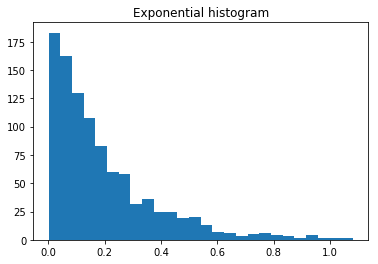

In [106]:
plt.hist(a, bins='auto')
plt.title("Exponential histogram")
plt.show()

In [46]:
### Conduct simulations
## Simulate representative generator then run a total 1000 simulations for each city
# Create a daily weather variable that is 1 or 0 to indicate whether random weather events occur (probabilities vary)
# weather is assumed to be statewide
weather_dum = []
for i in range(30):
    weather = np.random.uniform(0,1)
    if weather < .25:
        weather_dummy = 1
    else:
        weather_dummy = 0
    weather_dum.extend([weather_dummy]*24)

In [47]:
# Simulate representative generator then run a total 1000 simulations for each city
for i in range(1000):
    if i == 0:
        la_sim = jun_gen_data['generation'][jun_gen_data['city']=='los_angeles'].apply(lambda x: max(x-np.random.exponential(scale = .4),0) if x !=0 else x)
        rep_la_sim = la_sim
        continue
    la_sim = la_sim + jun_gen_data['generation'][jun_gen_data['city']=='los_angeles'].apply(lambda x: max(x-np.random.exponential(scale = .4),0) if x !=0 else x)
    
for i in range(1000):
    if i == 0:
        redd_sim = jun_gen_data['generation'][jun_gen_data['city']=='redding'].apply(lambda x: max(x-np.random.exponential(scale = .4),0) if x !=0 else x)
        rep_redd_sim = redd_sim
        continue
    redd_sim = redd_sim + jun_gen_data['generation'][jun_gen_data['city']=='redding'].apply(lambda x: max(x-np.random.exponential(scale = .4),0) if x !=0 else x)
    
for i in range(1000):
    if i == 0:
        fres_sim = jun_gen_data['generation'][jun_gen_data['city']=='fresno'].apply(lambda x: max(x-np.random.exponential(scale = .4),0) if x !=0 else x)
        rep_fres_sim = fres_sim
        continue
    fres_sim = fres_sim + jun_gen_data['generation'][jun_gen_data['city']=='fresno'].apply(lambda x: max(x-np.random.exponential(scale = .4),0) if x !=0 else x)

In [48]:
rep_la_sim.head(n=24)

3624    0.000000
3625    0.000000
3626    0.000000
3627    0.000000
3628    0.000000
3629    0.000000
3630    0.085280
3631    0.511341
3632    1.544347
3633    1.944991
3634    2.844749
3635    2.775005
3636    2.967843
3637    2.608506
3638    2.114849
3639    0.852652
3640    0.588559
3641    0.000000
3642    0.029552
3643    0.000000
3644    0.000000
3645    0.000000
3646    0.000000
3647    0.000000
Name: generation, dtype: float64

In [49]:
jun_gen_data['generation'][jun_gen_data['city']=='los_angeles'].head(n=24)

3624    0.000000
3625    0.000000
3626    0.000000
3627    0.000000
3628    0.000000
3629    0.150114
3630    0.500639
3631    0.969551
3632    1.572205
3633    2.268267
3634    2.880147
3635    2.955304
3636    3.111142
3637    2.724763
3638    2.305034
3639    1.590368
3640    0.863436
3641    0.166799
3642    0.051850
3643    0.000000
3644    0.000000
3645    0.000000
3646    0.000000
3647    0.000000
Name: generation, dtype: float64

In [50]:
### Create dataframe with load, simulated generation, representative variables, and the weather variables

In [51]:
jun_sim = {"la_sim": la_sim,
          "rep_la_sim": rep_la_sim,
          "redd_sim": redd_sim,
          "rep_redd_sim": rep_redd_sim,
          "fres_sim": fres_sim,
          "rep_fres_sim": rep_fres_sim,
          "weather": weather_dum}
jun_sim = pd.DataFrame(jun_sim)

In [52]:
## Merge with 'load_act,' then figure out how to run regressions

In [53]:
jun_sim.head()

,fres_sim,la_sim,redd_sim,rep_fres_sim,rep_la_sim,rep_redd_sim,weather
3624,0.0,0.0,0.0,0.0,0.0,0.0,0
3625,0.0,0.0,0.0,0.0,0.0,0.0,0
3626,0.0,0.0,0.0,0.0,0.0,0.0,0
3627,0.0,0.0,0.0,0.0,0.0,0.0,0
3628,0.0,0.0,0.0,0.0,0.0,0.0,0


In [54]:
## Merge with total load_act
# An index from 0 to 719 already exits. Use this to create an index on which to merge
jun_sim['index'] = ind

In [55]:
load_act.head()

,load_hr,day,hour,index,date_time
0,10.577134,1,0,0,2017-06-01 00:00:00
1,9.924829,1,1,1,2017-06-01 01:00:00
2,7.718577,1,2,2,2017-06-01 02:00:00
3,7.453556,1,3,3,2017-06-01 03:00:00
4,12.300450,1,4,4,2017-06-01 04:00:00


In [56]:
load_gen = load_act.merge(jun_sim,on='index')

In [57]:
load_gen.head()

,load_hr,day,hour,index,date_time,fres_sim,la_sim,redd_sim,rep_fres_sim,rep_la_sim,rep_redd_sim,weather
0,10.577134,1,0,0,2017-06-01 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0
1,9.924829,1,1,1,2017-06-01 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0
2,7.718577,1,2,2,2017-06-01 02:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0
3,7.453556,1,3,3,2017-06-01 03:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0
4,12.300450,1,4,4,2017-06-01 04:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0


In [58]:
def wtr_sim(load,wtr):
    return load - (.1*load*wtr)

In [59]:
# Decrease load_hr by 10% if weather=1
load_gen['load_hr'] = load_gen.apply(lambda x: wtr_sim(x['load_hr'],x['weather']),axis=1)

In [60]:
### Set up dynamic regression (basically OLS with lags)
## Identify lag lengths and create lags; run regression
## Create hourly dummy variables

In [61]:
from statsmodels.graphics.tsaplots import plot_acf

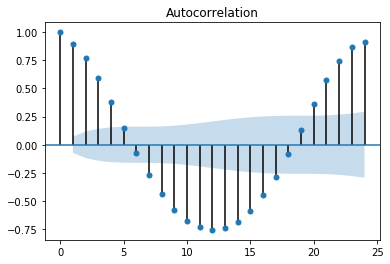

In [62]:
# Identifying the number of lags
plot_acf(load_gen.load_hr,lags=24)
# Create 1-hour and 24-hour lags

In [63]:
load_gen.head()

,load_hr,day,hour,index,date_time,fres_sim,la_sim,redd_sim,rep_fres_sim,rep_la_sim,rep_redd_sim,weather
0,10.577134,1,0,0,2017-06-01 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0
1,9.924829,1,1,1,2017-06-01 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0
2,7.718577,1,2,2,2017-06-01 02:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0
3,7.453556,1,3,3,2017-06-01 03:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0
4,12.300450,1,4,4,2017-06-01 04:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0


In [64]:
# Creates lags 1 and 24
load_gen['load_lag1'] = load_gen['load_hr'].shift()
load_gen['load_lag24'] = load_gen['load_hr'].shift(24)

In [65]:
# Create dummy variables
dummies = pd.get_dummies(load_gen.hour)

In [66]:
dummies.head()

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [67]:
load_gen = load_gen.join(dummies,how='inner')

In [68]:
load_gen.head()

,load_hr,day,hour,index,date_time,fres_sim,la_sim,redd_sim,rep_fres_sim,rep_la_sim,...,14,15,16,17,18,19,20,21,22,23
0,10.577134,1,0,0,2017-06-01 00:00:00,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,9.924829,1,1,1,2017-06-01 01:00:00,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,7.718577,1,2,2,2017-06-01 02:00:00,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,7.453556,1,3,3,2017-06-01 03:00:00,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,12.300450,1,4,4,2017-06-01 04:00:00,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [69]:
# Create a constant
load_gen = sm.add_constant(load_gen)

In [70]:
## Create aggregate load variable (replace load_gen): convert load_hr to kwh subtract "city_sim" variables from load_hr
load_gen['load_hr'] = (load_gen.load_hr*1000) - load_gen.fres_sim - load_gen.redd_sim - load_gen.la_sim

In [71]:
## Remove the 'city'_sim variables for the sake of sparsity
load_gen = load_gen.drop(['fres_sim','redd_sim','la_sim'],axis = 1)

In [72]:
# Return list of columnnames for reference
list(load_gen.columns.values)

['const',
 'load_hr',
 'day',
 'hour',
 'index',
 'date_time',
 'rep_fres_sim',
 'rep_la_sim',
 'rep_redd_sim',
 'weather',
 'load_lag1',
 'load_lag24',
 0L,
 1L,
 2L,
 3L,
 4L,
 5L,
 6L,
 7L,
 8L,
 9L,
 10L,
 11L,
 12L,
 13L,
 14L,
 15L,
 16L,
 17L,
 18L,
 19L,
 20L,
 21L,
 22L,
 23L]

In [73]:
sparse_model = sm.OLS(endog=load_gen['load_hr'], exog=load_gen[['const','weather','load_lag1','load_lag24']], missing='drop').fit()

In [74]:
print(sparse_model.summary())

                            OLS Regression Results                            
Dep. Variable:                load_hr   R-squared:                       0.872
Model:                            OLS   Adj. R-squared:                  0.872
Method:                 Least Squares   F-statistic:                     1576.
Date:                Sun, 25 Mar 2018   Prob (F-statistic):          9.62e-309
Time:                        14:30:06   Log-Likelihood:                -6834.1
No. Observations:                 696   AIC:                         1.368e+04
Df Residuals:                     692   BIC:                         1.369e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -432.2067    399.761     -1.081      0.2

In [75]:
extended_model = sm.OLS(endog=load_gen['load_hr'], exog=load_gen[['const','weather','load_lag1','load_lag24','rep_la_sim', \
                    ]], missing='drop').fit()

In [76]:
print(extended_model.summary())

                            OLS Regression Results                            
Dep. Variable:                load_hr   R-squared:                       0.897
Model:                            OLS   Adj. R-squared:                  0.897
Method:                 Least Squares   F-statistic:                     1507.
Date:                Sun, 25 Mar 2018   Prob (F-statistic):               0.00
Time:                        14:30:06   Log-Likelihood:                -6758.9
No. Observations:                 696   AIC:                         1.353e+04
Df Residuals:                     691   BIC:                         1.355e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        499.1891    366.286      1.363      0.1

In [77]:
## Create graphs of predicted vs. observed

In [78]:
prediction_plot = load_gen[['load_hr','rep_la_sim','load_lag1','load_lag24','weather','day','hour','index']]

In [79]:
prediction_plot = prediction_plot.dropna(axis=0,how='any')

In [80]:
len(prediction_plot)

696

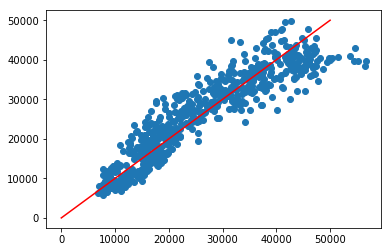

In [81]:
# Sparse model: actual vs. predicted
plt.close()
plt.scatter(prediction_plot['load_hr'],sparse_model.predict(),label='predicted')
plt.plot([0,50000],[0,50000],color='r')
plt.show()

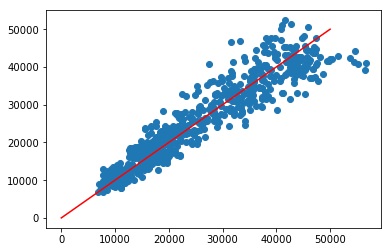

In [82]:
# Extended model: actual vs. predicted
plt.close()
plt.scatter(prediction_plot['load_hr'],extended_model.predict(),label='predicted')
plt.plot([0,50000],[0,50000],color='r')
plt.show()

In [83]:
## Graph residuals

In [84]:
# Create plot of residuals: prediction_plot = load_gen[['load_hr','rep_la_sim','load_lag1','load_lag24','weather','day','hour','index']]
resid_plot = prediction_plot[['index','day','hour','load_hr']]

In [85]:
# Introduces 'level_0', which indicates previous index if harmonization is needed
resid_plot.reset_index(inplace=True)

In [86]:
# Creates series both for prediction and residuals
resid_plot['spar_predict'] = pd.Series(sparse_model.predict())
resid_plot['ext_predict'] = pd.Series(extended_model.predict())

C:\Users\David\Anaconda2\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\David\Anaconda2\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [87]:
resid_plot['spar_resid'] = resid_plot['spar_predict'] - resid_plot['load_hr']
resid_plot['ext_resid'] = resid_plot['ext_predict'] - resid_plot['load_hr']

In [88]:
## Graph residuals

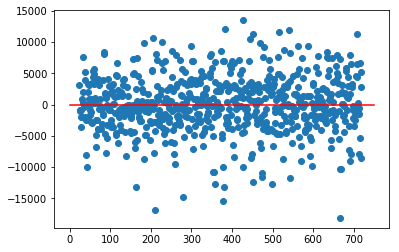

In [89]:
# Residuals across each hour in dataset
plt.close()
plt.scatter(resid_plot['index'],resid_plot['spar_resid'],label='predicted')
plt.plot([0,750],[0,0],color='r')
plt.show()

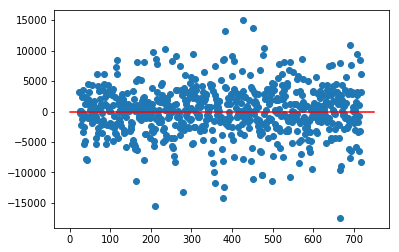

In [90]:
plt.close()
plt.scatter(resid_plot['index'],resid_plot['ext_resid'],label='predicted')
plt.plot([0,750],[0,0],color='r')
plt.show()

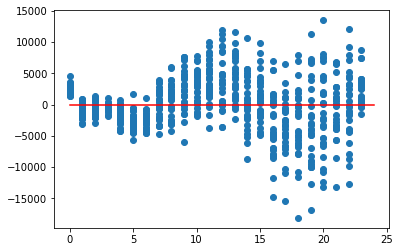

In [91]:
# Residuals by hour
plt.close()
plt.scatter(resid_plot['hour'],resid_plot['spar_resid'],label='predicted')
plt.plot([0,24],[0,0],color='r')
plt.show()

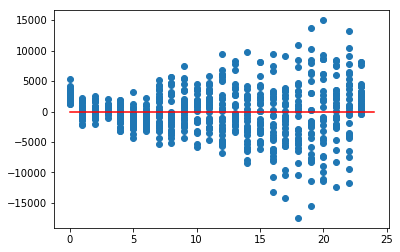

In [92]:
plt.close()
plt.scatter(resid_plot['hour'],resid_plot['ext_resid'],label='predicted')
plt.plot([0,24],[0,0],color='r')
plt.show()

In [93]:
dummy_model = sm.OLS(endog=load_gen['load_hr'], exog=load_gen[['const','weather','load_lag1','load_lag24','rep_la_sim', \
                    7L,8,9,10,11,12,13,14,15,16]], missing='drop').fit()

In [94]:
print(dummy_model.summary())

                            OLS Regression Results                            
Dep. Variable:                load_hr   R-squared:                       0.900
Model:                            OLS   Adj. R-squared:                  0.898
Method:                 Least Squares   F-statistic:                     436.3
Date:                Sun, 25 Mar 2018   Prob (F-statistic):               0.00
Time:                        14:30:13   Log-Likelihood:                -6750.2
No. Observations:                 696   AIC:                         1.353e+04
Df Residuals:                     681   BIC:                         1.360e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        795.1293    392.263      2.027      0.0

In [95]:
resid_plot['dum_predict'] = pd.Series(extended_model.predict())
resid_plot['dum_resid'] = resid_plot['dum_predict'] - resid_plot['load_hr']

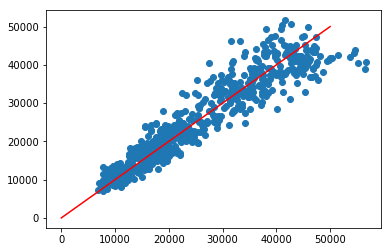

In [96]:
# Dummy model: actual vs. predicted
plt.close()
plt.scatter(prediction_plot['load_hr'],dummy_model.predict(),label='predicted')
plt.plot([0,50000],[0,50000],color='r')
plt.show()

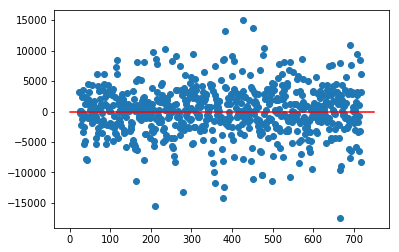

In [97]:
plt.close()
plt.scatter(resid_plot['index'],resid_plot['dum_resid'],label='predicted')
plt.plot([0,750],[0,0],color='r')
plt.show()

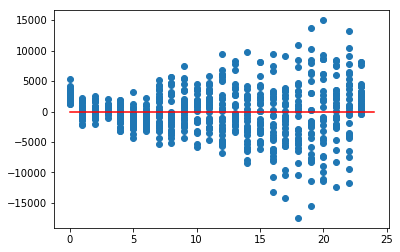

In [98]:
plt.close()
plt.scatter(resid_plot['hour'],resid_plot['dum_resid'],label='predicted')
plt.plot([0,24],[0,0],color='r')
plt.show()